In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import shap
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression

### **Dataset loading and displaying general info about it**

In [2]:
df = pd.read_csv(r'C:\Users\BW\Desktop\ETL project\ML_project\data\coffee_shop_revenue.csv') 
df.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
0,152,6.74,14,4,106.62,97,1547.81
1,485,4.50,12,8,57.83,744,2084.68
2,398,9.09,6,6,91.76,636,3118.39
3,320,8.48,17,4,462.63,770,2912.20
4,156,7.44,17,2,412.52,232,1663.42


In [3]:
df.shape

(2000, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Number_of_Customers_Per_Day  2000 non-null   int64  
 1   Average_Order_Value          2000 non-null   float64
 2   Operating_Hours_Per_Day      2000 non-null   int64  
 3   Number_of_Employees          2000 non-null   int64  
 4   Marketing_Spend_Per_Day      2000 non-null   float64
 5   Location_Foot_Traffic        2000 non-null   int64  
 6   Daily_Revenue                2000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 109.5 KB


In [5]:
df.describe()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,274.296000,6.261215,11.667000,7.947000,252.614160,534.893500,1917.325940
std,129.441933,2.175832,3.438608,3.742218,141.136004,271.662295,976.202746
min,50.000000,2.500000,6.000000,2.000000,10.120000,50.000000,-58.950000
25%,164.000000,4.410000,9.000000,5.000000,130.125000,302.000000,1140.085000
50%,275.000000,6.300000,12.000000,8.000000,250.995000,540.000000,1770.775000
75%,386.000000,8.120000,15.000000,11.000000,375.352500,767.000000,2530.455000
max,499.000000,10.000000,17.000000,14.000000,499.740000,999.000000,5114.600000


In [6]:
df.isnull().sum()

Number_of_Customers_Per_Day    0
Average_Order_Value            0
Operating_Hours_Per_Day        0
Number_of_Employees            0
Marketing_Spend_Per_Day        0
Location_Foot_Traffic          0
Daily_Revenue                  0
dtype: int64

### **Helper functions**

In [48]:
def get_crossval_metrics(models_dict, xtrain, ytrain):
    """
    Perform cross-validation on a set of models and print average regression metrics.

    Parameters
    ----------
    models_dict : dict
        A dictionary where the keys are model names (str) and the values are model instances
        that implement the scikit-learn API (fit/predict).
    
    xtrain : array-like or pandas DataFrame of shape (n_samples, n_features)
        The training input samples.

    ytrain : array-like or pandas Series of shape (n_samples,)
        The target values for training.

    Returns
    -------
    None
        This function prints the average R2, MAE, RMSE, and MSE scores for each model.
    
    Notes
    -----
    Uses 5-fold cross-validation with a fixed random state (3) and shuffling enabled.
    Metrics used:
        - R2 Score (`r2`)
        - Mean Absolute Error (`neg_mean_absolute_error`)
        - Root Mean Squared Error (`neg_root_mean_squared_error`)
        - Mean Squared Error (`neg_mean_squared_error`)
    """
    # Define 5-fold cross-validation strategy with shuffling and fixed random seed
    cv_type = KFold(n_splits=5, shuffle=True, random_state=3)

    # Iterate over all models in the provided dictionary
    for model_name, model in models_dict.items():
        print(f"Cross validating model: {model_name}")

        # Compute mean R2 score across folds
        r2_mean = np.mean(cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='r2'))

        # Compute mean MAE across folds (negated because sklearn returns negative MAE)
        mae_mean = -np.mean(cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='neg_mean_absolute_error'))

        # Compute mean RMSE across folds (negated because sklearn returns negative RMSE)
        rmse_mean = -np.mean(cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='neg_root_mean_squared_error'))

        # Compute mean MSE across folds (negated because sklearn returns negative MSE)
        mse_mean = -np.mean(cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='neg_mean_squared_error'))

        # Print the averaged cross-validation results
        print(f"R2 Score: {r2_mean:.4f}")
        print(f"MAE: {mae_mean:.4f}")
        print(f"RMSE: {rmse_mean:.4f}")
        print(f"MSE: {mse_mean:.4f}")
        print('-' * 35)

'-------------------------------------------------------------------------------------------------------------------------------------------------------------------'

def train_models(models_dict, x_train, y_train, x_test ,y_test):
    """
    Train and evaluate multiple regression models using test data.

    Parameters
    ----------
    models_dict : dict
        Dictionary containing model names as keys and scikit-learn model instances as values.

    x_train : array-like of shape (n_samples, n_features)
        Feature set used for training the models.

    y_train : array-like of shape (n_samples,)
        Target variable used for training the models.

    x_test : array-like of shape (n_samples, n_features)
        Feature set used for testing the models.

    y_test : array-like of shape (n_samples,)
        Target variable used for testing the models.

    Returns
    -------
    None
        Prints evaluation metrics (R2, RMSE, MAE, MSE) for each model in the dictionary.
    """
    # Loop over each model in the dictionary
    for model_name, model in models_dict.items():
        # Fit the model to training data
        model.fit(x_train, y_train)
        
        # Make predictions on the test data
        y_pred = model.predict(x_test)

        # Calculate performance metrics
        r2 = r2_score(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Print evaluation metrics
        print(f'The Metrics for model: {model_name}')
        print(f'The R2 score is: {r2}')
        print(f'The RMSE is: {rmse}')
        print(f'The MAE is: {mae}')
        print(f'The MSE is: {mse}')
        print('-' * 45)

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------'

def hyperparameter_tune(model, param_grid, xtrain, ytrain, xtest, ytest, model_name, json_filename, model_filename):
    """
    Perform hyperparameter tuning using GridSearchCV and evaluate the best model.

    Parameters
    ----------
    model : estimator object
        A scikit-learn compatible model instance (e.g., RandomForestRegressor, SVR, etc.).

    param_grid : dict
        Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.

    xtrain : array-like of shape (n_samples, n_features)
        Training feature set.

    ytrain : array-like of shape (n_samples,)
        Target variable for training.

    xtest : array-like of shape (n_samples, n_features)
        Testing feature set.

    ytest : array-like of shape (n_samples,)
        Target variable for testing.

    model_name : str
        Name of the model, used for display/logging purposes.

    json_filename : str
        Path where the best parameters (from GridSearch) should be saved in JSON format.

    model_filename : str
        Path where the best trained model should be saved using joblib.

    Returns
    -------
    best_model : estimator object
        The trained model with the best-found hyperparameters.

    best_params : dict
        Dictionary of the best hyperparameters found during tuning.

    metrics : dict
        Dictionary containing evaluation metrics: RMSE, MAE, R2, and MSE.
    """

    # Initialize GridSearchCV with specified parameters and 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        refit=True
    )
    
    # Fit the grid search to the training data
    grid_search.fit(xtrain, ytrain)
    
    # Extract best parameters and best model from the search
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Predict using the best model on test data
    predictions = best_model.predict(xtest)

    # Compute evaluation metrics
    rmse = root_mean_squared_error(ytest, predictions)
    r2 = r2_score(ytest, predictions)
    mae = mean_absolute_error(ytest, predictions)
    mse = mean_squared_error(ytest, predictions)

    # Save the best parameters to a JSON file
    with open(json_filename, "w") as f:
        json.dump(best_params, f)

    # Save the best model using joblib
    joblib.dump(best_model, model_filename)

    # Print results and file paths
    print('-' * 40)
    print(f"Best Parameters for {model_name}:", best_params)
    print(f"Root Mean Squared Error: {rmse}.")
    print(f"R2 Score: {r2}.")
    print(f"Mean Absolute Error: {mae}.")
    print(f'Mean Squared Error: {mse}')

    print(f"Model saved as: {model_filename}")
    print('-' * 40)
    
    # Return model, best parameters, and evaluation metrics
    return best_model, best_params, {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MSE': mse}

### **Splitting dataset into train and test splits**

In [8]:
X = df.drop("Daily_Revenue", axis=1)
y = df["Daily_Revenue"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.head(3)

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic
968,352,4.02,17,7,285.32,835
240,344,4.44,12,10,454.80,109
819,129,8.80,9,6,52.20,275


In [10]:
y_train.head(3)

968    1991.15
240    2073.81
819    1296.22
Name: Daily_Revenue, dtype: float64

In [11]:
X_test.head(3)

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic
1860,463,7.19,6,9,214.55,558
353,148,7.15,7,12,184.71,244
1333,460,3.48,16,10,456.30,254


In [12]:
y_test.head()

1860    3443.69
353     1021.08
1333    2384.42
905     2198.35
1289    1988.89
Name: Daily_Revenue, dtype: float64

### **Models dictonary to use with cross validation and model training function**

In [13]:
models_dict = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "SVR": SVR(),
    "XGBoostRegressor": XGBRegressor(),
    "KNN": KNeighborsRegressor()
}

### **Cross validation scores**

In [15]:
get_crossval_metrics(models_dict, X_train, y_train)

Cross validating model: LinearRegression
R2 Score: 0.8879
MAE: 257.1839
RMSE: 326.0001
MSE: 106338.0204
-----------------------------------
Cross validating model: Ridge
R2 Score: 0.8879
MAE: 257.1858
RMSE: 326.0003
MSE: 106338.0983
-----------------------------------
Cross validating model: Lasso
R2 Score: 0.8879
MAE: 257.1844
RMSE: 325.9855
MSE: 106328.2881
-----------------------------------
Cross validating model: ElasticNet
R2 Score: 0.8850
MAE: 260.4522
RMSE: 330.1093
MSE: 109027.5962
-----------------------------------
Cross validating model: DecisionTreeRegressor
R2 Score: 0.8879
MAE: 260.3300
RMSE: 326.7502
MSE: 106549.6381
-----------------------------------
Cross validating model: RandomForestRegressor
R2 Score: 0.9434
MAE: 187.5089
RMSE: 231.7109
MSE: 53802.9559
-----------------------------------
Cross validating model: SVR
R2 Score: 0.0331
MAE: 758.9809
RMSE: 959.0007
MSE: 920603.5750
-----------------------------------
Cross validating model: XGBoostRegressor
R2 Score: 0

## 📊 **Cross-Validation Results Analysis**

The following models were evaluated using 5-fold cross-validation. Metrics reported include R2 Score, MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and MSE (Mean Squared Error). All values are averages across folds.

### 🔍 **Observations**:

#### ✅ **Top Performers**:
- **RandomForestRegressor**
  - **R2 Score:** 0.9434 (highest)
  - **RMSE:** 231.71 (lowest)
  - **MAE:** 187.50
  - **MSE:** 53,802.955
  - 💡 This model shows the best overall performance with the lowest error metrics and highest explanatory power.

- **XGBoostRegressor**
  - **R2 Score:** 0.9360
  - **RMSE:** 246.40
  - **MAE:** 198.19
  - **MSE:** 60,799.37
  - 💡 Slightly behind RandomForest, but still excellent in performance.

#### 🟢 **Strong Linear Models**:
- **LinearRegression, Ridge, and Lasso**
  - **R2 Scores:** ~0.8879
  - **MAE:** ~257.18
  - **RMSE:** ~326.00
  - **MSE:** ~106,338
  - 💡 Linear models performed similarly and decently well, though not as strong as ensemble methods.

- **ElasticNet**
  - **R2 Score:** 0.8850 (slightly lower)
  - **Higher RMSE and MAE** compared to other linear models.
  - 💡 Slightly underperforms vs Ridge and Lasso.

#### 🟡 **Moderate Performance**:
- **DecisionTreeRegressor**
  - **R2 Score:** 0.8879
  - **RMSE:** 326.75
  - **MAE:** 260.33
  - **MSE:** 106,549.63
  - 💡 Performs similarly to linear models but less stable.

#### 🔻 **Underperformers**:
- **KNN**
  - **R2 Score:** 0.5064
  - **RMSE:** 684.93
  - **MAE:** 532.67
  - **MSE:** 469,264.69
  - 💡 Not suitable.

- **SVR**
  - **R2 Score:** 0.0331
  - **RMSE:** 959.00 (highest)
  - **MAE:** 758.98
  - **MSE:** 920,603.57 (very high)
  - ❌ Performs poorly.

---

### ✅ **Conclusion**:

- **Recommended Models for Further Tuning:**
  - `RandomForestRegressor`
  - `XGBoostRegressor`

- **Linear models (LinearRegression, Ridge, Lasso)** are acceptable choices when interpretability, simplicity, or faster inference is needed over raw predictive performance.

- **DecisionTreeRegressor** showed similar performance to linear models with slightly higher MAE and lower R2, but may be prone to overfitting. It can still be useful with pruning or as a base model for ensembles.

- **SVR and KNN** are not recommended for this problem in their current form, as they produced significantly higher error metrics. Substantial tuning or preprocessing (like scaling or feature engineering) would be needed to improve their performance.

### **Feature selection**

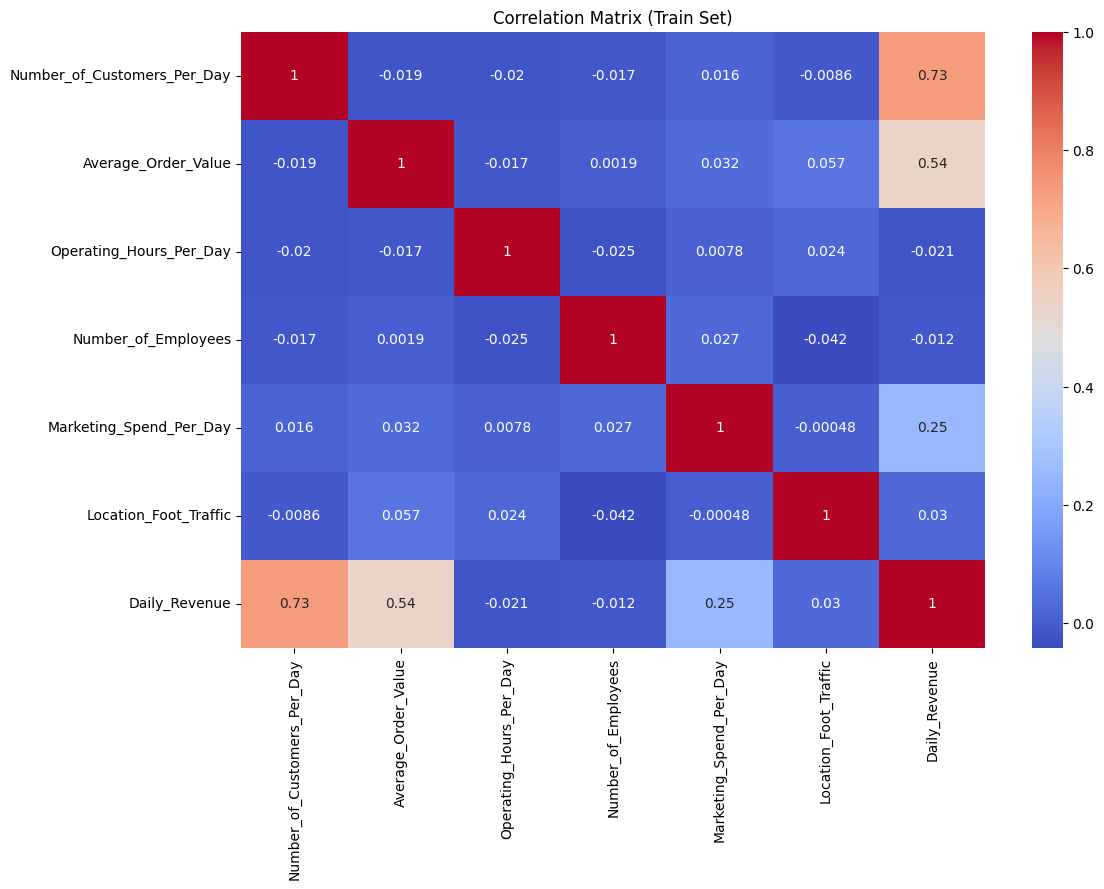

In [16]:
train_corr = X_train.copy()
train_corr["Daily_Revenue"] = y_train

plt.figure(figsize=(12, 8))
sns.heatmap(train_corr.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Train Set)")
plt.show()

## 📈 **Correlation Analysis with Target Variable**: `Daily_Revenue`

The table below shows the Pearson correlation coefficients between features and the target variable `Daily_Revenue`.

### 🔍 **Key Observations**:

#### ✅ **Strong Positive Correlation**:
- **Number_of_Customers_Per_Day**: **0.73**
  - This is the **most strongly correlated** feature with `Daily_Revenue`.
  - 💡 As the number of customers increases, revenue tends to rise significantly.
  - This is expected, as more customers generally lead to more sales.

- **Average_Order_Value**: **0.54**
  - A strong correlation indicating that higher order values contribute substantially to daily revenue.
  - 💡 This suggests that strategies to increase per-customer spending could be effective.

#### 🟡 **Moderate Correlation**:
- **Marketing_Spend_Per_Day**: **0.25**
  - There is a moderate positive correlation with revenue.
  - 💡 Indicates that marketing has a noticeable impact on revenue, though not as strong as customer count or order value.

#### 🔘 **Weak/Negligible Correlations**:
- **Location_Foot_Traffic**: **0.03**
  - Very weak correlation with revenue.
  - 💡 Possibly suggests that foot traffic doesn't translate directly into paying customers, or that other variables mediate this effect.

- **Operating_Hours_Per_Day**: **-0.021**
- **Number_of_Employees**: **-0.012**
  - Negligible or slightly negative correlations.
  - 💡 These operational variables don't show a meaningful direct relationship with revenue in this dataset.

---

### 📌 **Summary**:
- The **top drivers** of `Daily_Revenue` are:
  1. `Number_of_Customers_Per_Day`
  2. `Average_Order_Value`
  3. `Marketing_Spend_Per_Day` (to a lesser extent)

- Features like `Operating_Hours_Per_Day`, `Number_of_Employees`, and `Location_Foot_Traffic` show **minimal direct influence** on revenue based on correlation alone.

- 💡 Further analysis (e.g., mutual info with select k best, feature importance from models) may uncover non-linear or interaction effects not captured by simple correlation.


### **Feature importances using randomforest regressor**

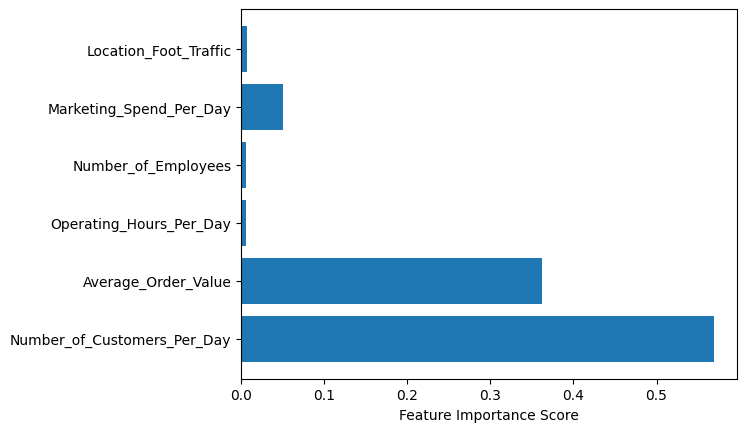

In [17]:
model_rndf_feature_importances = RandomForestRegressor()
model_rndf_feature_importances.fit(X_train, y_train)
importance = model_rndf_feature_importances.feature_importances_
feature_names = X_train.columns
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance Score")
plt.show()

In [18]:
var = zip(feature_names, importance)
for i in var:
    print(i)

('Number_of_Customers_Per_Day', np.float64(0.56869118375603))
('Average_Order_Value', np.float64(0.36226201767339666))
('Operating_Hours_Per_Day', np.float64(0.005568344296236588))
('Number_of_Employees', np.float64(0.005255572541973095))
('Marketing_Spend_Per_Day', np.float64(0.05088638284253574))
('Location_Foot_Traffic', np.float64(0.00733649888982796))


## 🌲 **Feature Importance Analysis from Random Forest Regressor**

The following feature importances were derived from a trained Random Forest Regressor model. These values represent how much each feature contributes to predicting the target variable `Daily_Revenue`.

### 🔢 **Feature Importances**:

| Feature                      | Importance |
|-----------------------------|------------|
| Number_of_Customers_Per_Day | **0.5686** |
| Average_Order_Value         | **0.3622** |
| Marketing_Spend_Per_Day     | 0.0508     |
| Location_Foot_Traffic       | 0.0073     |
| Operating_Hours_Per_Day     | 0.0055     |
| Number_of_Employees         | 0.0052     |

### 🧠 **Interpretation**:

#### ✅ **Highly Influential Features**:
- **Number_of_Customers_Per_Day** (**56.86% importance**)
  - The most critical feature in predicting `Daily_Revenue`.
  - 💡 Reinforces the strong correlation previously observed. Customer volume is the primary driver of revenue.

- **Average_Order_Value** (**36.22% importance**)
  - Second most important feature.
  - 💡 Suggests that strategies to increase how much each customer spends can significantly impact revenue.

#### 🟡 **Moderately to Weakly Influential**:
- **Marketing_Spend_Per_Day** (**0.050% importance**)
  - Has a smaller, but still meaningful impact.
  - 💡 May have an indirect effect by influencing customer behavior or visibility.

#### 🔻 **Negligible Impact Features**:
- **Location_Foot_Traffic**, **Operating_Hours_Per_Day**, and **Number_of_Employees**
  - Each contributes less than 1% to the model’s predictive power.
  - 💡 These features may not have a direct or linear relationship with revenue, or their effects may be captured through other variables.

---

### **Mutual info regression with select k best**

In [19]:
selector = SelectKBest(score_func=mutual_info_regression, k="all")
selector.fit(X_train, y_train)

mi_scores = pd.Series(selector.scores_, index=X_train.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_scores)

Mutual Information Scores:
 Number_of_Customers_Per_Day    0.438449
Average_Order_Value            0.236636
Marketing_Spend_Per_Day        0.018889
Operating_Hours_Per_Day        0.007187
Location_Foot_Traffic          0.001006
Number_of_Employees            0.000000
dtype: float64


## 📊 **Mutual Information Feature Analysis**

Mutual Information (MI) measures the amount of information a feature contributes to predicting the target variable `Daily_Revenue`. Unlike correlation, MI captures **non-linear relationships** and **interactions** between variables and the target.

### 🔢 **Mutual Information Scores**:

| Feature                      | MI Score   |
|-----------------------------|------------|
| Number_of_Customers_Per_Day | **0.4384** |
| Average_Order_Value         | **0.2366** |
| Marketing_Spend_Per_Day     | 0.0188     |
| Operating_Hours_Per_Day     | 0.0071     |
| Location_Foot_Traffic       | 0.0010     |
| Number_of_Employees         | 0.0000     |

### 🧠 **Interpretation**:

#### ✅ **Most Informative Features**:
- **Number_of_Customers_Per_Day** (**0.4384**)  
  - The most informative feature for predicting `Daily_Revenue`.
  - 💡 Strongly supports previous findings from correlation and feature importance analyses.

- **Average_Order_Value** (**0.2366**)  
  - Also highly informative.
  - 💡 Indicates substantial non-linear dependency with revenue.

#### 🟡 **Weakly Informative**:
- **Marketing_Spend_Per_Day** (**0.0188**)  
  - Has some predictive power, though relatively minor.
  - 💡 May affect revenue indirectly or have effects better captured with more engineered features.

#### 🔻 **Negligible or No Information**:
- **Operating_Hours_Per_Day**, **Location_Foot_Traffic**, and **Number_of_Employees**
  - Very low or zero MI scores.
  - 💡 These features provide little to no information gain about `Daily_Revenue` in their current form.

---

### 📌 **Conclusion**:

- Focus model development and business strategies around:
  - `Number_of_Customers_Per_Day`
  - `Average_Order_Value`

- Features like `Marketing_Spend_Per_Day` might add some predictive power.

### 🔍 Feature Selection Summary

To determine the most relevant features for predicting the target (`Daily_Revenue`), I applied three different feature selection techniques:

1. **Pearson Correlation Analysis**
2. **Feature Importances from RandomForestRegressor**
3. **Mutual Information using `SelectKBest` with `mutual_info_regression`**

All three methods consistently identified the same top features:

- `Number_of_Customers_Per_Day`
- `Average_Order_Value`
- `Marketing_Spend_Per_Day`

Based on this agreement across multiple selection strategies, I chose to select these three features for model training and evaluation.

In [28]:
X_train_selected_features = X_train[['Number_of_Customers_Per_Day', 'Average_Order_Value', 'Marketing_Spend_Per_Day']]
X_test_selected_features = X_test[['Number_of_Customers_Per_Day', 'Average_Order_Value', 'Marketing_Spend_Per_Day']]

In [31]:
X_train_selected_features.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
968,352,4.02,285.32
240,344,4.44,454.80


In [32]:
X_test_selected_features.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
1860,463,7.19,214.55
353,148,7.15,184.71


### **Cross validation using selected features**

In [33]:
get_crossval_metrics(models_dict=models_dict, xtrain=X_train_selected_features, ytrain=y_train)

Cross validating model: LinearRegression
R2 Score: 0.8883
MAE: 256.5323
RMSE: 325.3066
MSE: 105887.0538
-----------------------------------
Cross validating model: Ridge
R2 Score: 0.8883
MAE: 256.5340
RMSE: 325.3067
MSE: 105887.0966
-----------------------------------
Cross validating model: Lasso
R2 Score: 0.8883
MAE: 256.5417
RMSE: 325.3076
MSE: 105887.6166
-----------------------------------
Cross validating model: ElasticNet
R2 Score: 0.8855
MAE: 259.7385
RMSE: 329.3664
MSE: 108543.7223
-----------------------------------
Cross validating model: DecisionTreeRegressor
R2 Score: 0.8910
MAE: 257.6504
RMSE: 319.6533
MSE: 103432.6732
-----------------------------------
Cross validating model: RandomForestRegressor
R2 Score: 0.9435
MAE: 186.6347
RMSE: 231.9444
MSE: 53936.1282
-----------------------------------
Cross validating model: SVR
R2 Score: 0.1344
MAE: 713.1069
RMSE: 907.3407
MSE: 824192.9983
-----------------------------------
Cross validating model: XGBoostRegressor
R2 Score: 0

## **Feature Selection Impact Analysis**

To evaluate the impact of feature selection on model performance, I applied three feature selection techniques: Pearson Correlation, Mutual Information with `SelectKBest`, and Model-Based Feature Importance. All three methods consistently highlighted the same key features:

- `Number_of_Customers_Per_Day`
- `Average_Order_Value`
- `Marketing_Spend_Per_Day`

Based on this agreement, I selected these three features for the modeling phase. Below is a comparative analysis of cross-validation performance **before and after** feature selection.

---

### ✅ **Models That Improved After Feature Selection**
| Model                  | Metric        | Before (All Features) | After (Selected Features) | Change      |
|------------------------|----------------|------------------------|----------------------------|-------------|
| **LinearRegression**   | R² Score       | 0.8879                 | 0.8883                     | 🔼 +0.0004   |
|                        | MAE            | 257.1839               | 256.5323                   | 🔽 -0.6516   |
|                        | RMSE           | 326.0001               | 325.3066                   | 🔽 -0.6935   |
| **Ridge**              | R² Score       | 0.8879                 | 0.8883                     | 🔼 +0.0004   |
|                        | MAE            | 257.1858               | 256.5340                   | 🔽 -0.6518   |
|                        | RMSE           | 326.0003               | 325.3067                   | 🔽 -0.6936   |
| **Lasso**              | R² Score       | 0.8879                 | 0.8883                     | 🔼 +0.0004   |
|                        | MAE            | 257.1844               | 256.5417                   | 🔽 -0.6427   |
|                        | RMSE           | 325.9855               | 325.3076                   | 🔽 -0.6779   |
| **ElasticNet**         | R² Score       | 0.8850                 | 0.8855                     | 🔼 +0.0005   |
|                        | MAE            | 260.4522               | 259.7385                   | 🔽 -0.7137   |
|                        | RMSE           | 330.1093               | 329.3664                   | 🔽 -0.7429   |
| **DecisionTree**       | R² Score       | 0.8879                 | 0.8910                     | 🔼 +0.0031   |
|                        | MAE            | 260.3300               | 257.6504                   | 🔽 -2.6796   |
|                        | RMSE           | 326.7502               | 319.6533                   | 🔽 -7.0969   |
| **RandomForest**       | R² Score       | 0.9434                 | 0.9435                     | 🔼 +0.0001   |
|                        | MAE            | 187.5089               | 186.6347                   | 🔽 -0.8742   |
|                        | RMSE           | 231.7109               | 231.9444                   | 🔼 +0.2335   |
| **SVR**                | R² Score       | 0.0331                 | 0.1344                     | 🔼 +0.1013   |
|                        | MAE            | 758.9809               | 713.1069                   | 🔽 -45.8740  |
|                        | RMSE           | 959.0007               | 907.3407                   | 🔽 -51.6600  |
| **XGBoost**            | R² Score       | 0.9360                 | 0.9371                     | 🔼 +0.0011   |
|                        | MAE            | 198.1985               | 196.6376                   | 🔽 -1.5609   |
|                        | RMSE           | 246.4050               | 244.2685                   | 🔽 -2.1365   |
| **KNN**                | R² Score       | 0.5064                 | 0.5200                     | 🔼 +0.0136   |
|                        | MAE            | 532.6798               | 526.7434                   | 🔽 -5.9364   |
|                        | RMSE           | 684.9324               | 674.4741                   | 🔽 -10.4583  |

---

### 🔍 **Conclusion**

- **All models** experienced either marginal or clear performance improvement after selecting only the top 3 features.
- **Linear, Ridge, Lasso, ElasticNet, and DecisionTree** models showed slight improvements in R² and slight reductions in error metrics.
- **Tree-based models (RandomForest, XGBoost, DecisionTree)** maintained or slightly improved performance even with reduced input dimensionality, showing robustness.
- **SVR and KNN**, which struggled with the full feature set, also benefited notably from simplification.
- These results justify the decision to proceed with the selected features, as they simplify the pipeline and slightly improve generalization, while also improving interpretability and training efficiency.



### **Standard scaling the splits**

In [35]:
std_scaler = StandardScaler()

X_train_scaled = pd.DataFrame(std_scaler.fit_transform(X_train_selected_features), columns=X_train_selected_features.columns)
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test_selected_features), columns=X_test_selected_features.columns)

In [36]:
X_train_scaled.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
0,0.598695,-1.036230,0.218925
1,0.536962,-0.843044,1.408468


In [37]:
X_test_scaled.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
0,1.455242,0.421860,-0.277794
1,-0.975499,0.403461,-0.487234


### **Model training and evaluation**

In [38]:
train_models(models_dict=models_dict, x_train=X_train_scaled, y_train=y_train, x_test=X_test_scaled, y_test=y_test)

The Metrics for model: LinearRegression
The R2 score is: 0.895262809862764
The RMSE is: 312.830854621557
The MAE is: 244.3606106134222
The MSE is: 97863.14360325376
---------------------------------------------
The Metrics for model: Ridge
The R2 score is: 0.8952775429093774
The RMSE is: 312.8088513882725
The MAE is: 244.3667610766415
The MSE is: 97849.37750685036
---------------------------------------------
The Metrics for model: Lasso
The R2 score is: 0.8952865076394975
The RMSE is: 312.79546215435613
The MAE is: 244.3869135986437
The MSE is: 97841.00114435724
---------------------------------------------
The Metrics for model: ElasticNet
The R2 score is: 0.8004222142195925
The RMSE is: 431.83239791154875
The MAE is: 333.5828003901634
The MSE is: 186479.21988603816
---------------------------------------------
The Metrics for model: DecisionTreeRegressor
The R2 score is: 0.8943295635834752
The RMSE is: 314.22148182372894
The MAE is: 255.9926
The MSE is: 98735.1396395
---------------

### 📊 **Model Evaluation Summary (Using Selected & Scaled Features)**

This analysis evaluates model performance on the test set using the selected features and standardized scaling. The key regression metrics analyzed are **R² Score**, **RMSE**, **MAE**, and **MSE**.

---

#### 🔝 **Best Performing Models**

1. **RandomForestRegressor**
   - **R²:** 0.9485 (Highest)
   - **RMSE:** 219.25 (Lowest)
   - **MAE:** 177.66 (Lowest)
   - **MSE:** 48,072.28 (Lowest)
   - ✅ *Clearly the best performer across all metrics. Will benefit from hyperparameter tuning for further gains.*

2. **KNN**
   - **R²:** 0.9422
   - **RMSE:** 232.36
   - **MAE:** 185.03
   - **MSE:** 53,993.25
   - ✅ *Performed surprisingly well. Could benefit from neighbor tuning and distance weighting.*

2. **XGBoostRegressor**
   - **R²:** 0.9395
   - **RMSE:** 237.73
   - **MAE:** 188.38
   - **MSE:** 56,515.08
   - ✅ *Second-best performer with strong generalization and low error. A good candidate for hyperparameter optimization.*

---

#### 🟡 **Competitive Models**

4. **Linear Models (LinearRegression, Ridge, Lasso)**
   - **R²:** ~0.8953 (all three)
   - **RMSE:** ~312.8
   - **MAE:** ~244.4
   - **MSE:** ~97,850–97,863
   - ⚠️ *Stable and interpretable, but not as performant as ensemble methods.*

5. **DecisionTreeRegressor**
   - **R²:** 0.8943
   - **RMSE:** 314.22
   - **MAE:** 255.99
   - **MSE:** 98,735.14
   - ⚠️ *Slightly worse than linear models.*

---

#### 🔻 **Underperforming Models**

6. **ElasticNet**
   - **R²:** 0.8004
   - **RMSE:** 431.83
   - **MAE:** 333.58
   - **MSE:** 186,479.22
   - ❌ *Shows weak generalization—poor choice for this dataset without further feature engineering.*

7. **SVR**
   - **R²:** 0.2381
   - **RMSE:** 843.74
   - **MAE:** 662.38
   - **MSE:** 711,903.86
   - ❌ *Severely underperforming.*

---


Focusing hyperparameter search on the **top three models**:
- `RandomForestRegressor`
- `KNN`
- `XGBoostRegressor`


These models provide a strong trade-off between accuracy and robustness and have shown significant improvement over baseline linear models.

---

### **Hyper-parameter tuning**

In [55]:
rndf_frst_model = RandomForestRegressor()
xgboost_model = XGBRegressor()
knn_model = KNeighborsRegressor()

In [57]:
param_grid_rf = {
    "n_estimators": [50, 100, 200],  
    "max_depth": [3, 5, 10, 15, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4],  
    "max_features": ["sqrt", "log2", None], 
    "bootstrap": [True, False]  
}

param_grid_xgb = {
    "n_estimators": [50, 100, 200],  
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  
    "max_depth": [3, 5, 10, 15], 
    "min_child_weight": [1, 3, 5],  
    "subsample": [0.6, 0.8, 1.0], 
    "colsample_bytree": [0.6, 0.8, 1.0], 
    "gamma": [0, 0.1, 0.2, 0.5]  
}

param_grid_knn = {
    "n_neighbors": [3, 5, 7, 10],  
    "weights": ["uniform", "distance"],  
    "metric": ["euclidean", "manhattan", "minkowski"],  
    "p": [1, 2]  # `1 = Manhattan`, `2 = Euclidean`
}

### **Hyper-parameter tuning randomforest regressor**

In [58]:
best_model_rndf, best_params_rndf, rndf_metrics = hyperparameter_tune(model=rndf_frst_model, param_grid=param_grid_rf, xtrain=X_train_scaled, ytrain=y_train,
                                                                    xtest=X_test_scaled, ytest=y_test, model_name='Randomforest regressor',
                                                                    json_filename='Randomforest_hypertuned_parameters.json', 
                                                                    model_filename='Randomforest_hypertuned_model.pkl')

----------------------------------------
Best Parameters for Randomforest regressor: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Root Mean Squared Error: 220.73496743498498.
R2 Score: 0.9478536362318555.
Mean Absolute Error: 178.59768898099753.
Mean Squared Error: 48723.925848523875
Model saved as: Randomforest_hypertuned_model.pkl
----------------------------------------


In [59]:
best_model_knn, best_params_knn, knn_metrics = hyperparameter_tune(model=knn_model, param_grid=param_grid_knn, xtrain=X_train_scaled, ytrain=y_train,
                                                                    xtest=X_test_scaled, ytest=y_test, model_name='KNN regressor',
                                                                    json_filename='KNN_hypertuned_parameters.json', 
                                                                    model_filename='KNN_hypertuned_model.pkl')

----------------------------------------
Best Parameters for KNN regressor: {'metric': 'euclidean', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Root Mean Squared Error: 225.28991283476284.
R2 Score: 0.9456793134459637.
Mean Absolute Error: 181.47411205632343.
Mean Squared Error: 50755.54482509504
Model saved as: KNN_hypertuned_model.pkl
----------------------------------------


In [60]:
best_model_xgbst, best_params_xgbst, xgbst_metrics = hyperparameter_tune(model=xgboost_model, param_grid=param_grid_xgb, xtrain=X_train_scaled, ytrain=y_train,
                                                                    xtest=X_test_scaled, ytest=y_test, model_name='Xgboost regressor',
                                                                    json_filename='Xgboost_hypertuned_parameters.json', 
                                                                    model_filename='Xgboost_hypertuned_model.pkl')

----------------------------------------
Best Parameters for Xgboost regressor: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.6}
Root Mean Squared Error: 207.57866302091205.
R2 Score: 0.9538844728827574.
Mean Absolute Error: 168.25035345458986.
Mean Squared Error: 43088.90134154936
Model saved as: Xgboost_hypertuned_model.pkl
----------------------------------------


## ✅ **Best Performing Model: XGBoost Regressor**

After evaluating all three hypertuned regression models on the test dataset, **XGBoost Regressor** stands out as the best performing model based on multiple key metrics:

### 🔍 **Performance Comparison**:

| Metric      | Random Forest | KNN         | **XGBoost** (Best) |
|-------------|----------------|-------------|--------------------|
| **RMSE**    | 220.73         | 225.28      | **207.57**         |
| **R² Score**| 0.9478         | 0.9456      | **0.9538**         |
| **MAE**     | 178.59         | 181.47      | **168.25**         |
| **MSE**     | 48,723.92      | 50,755.54   | **43,088.90**      |

###  **Why XGBoost is the Best**:
- **Lowest RMSE**: Indicates XGBoost has the smallest average error magnitude.
- **Highest R² Score**: Suggests XGBoost explains the highest proportion of variance in the target variable.
- **Lowest MAE and MSE**: Confirms it makes fewer and smaller prediction errors overall.

Thus, based on superior accuracy and error minimization, **XGBoost Regressor is the optimal choice for deployment or further use**.

### **SHAP**

In [ ]:
explainer = shap.Explainer(best_model_xgbst)  
shap_values = explainer(X_test_scaled)

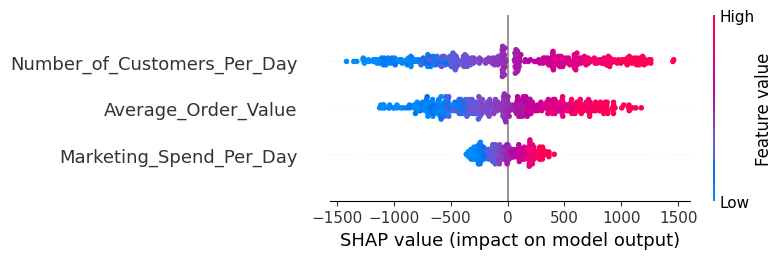

In [64]:
shap.summary_plot(shap_values, X_test_scaled)

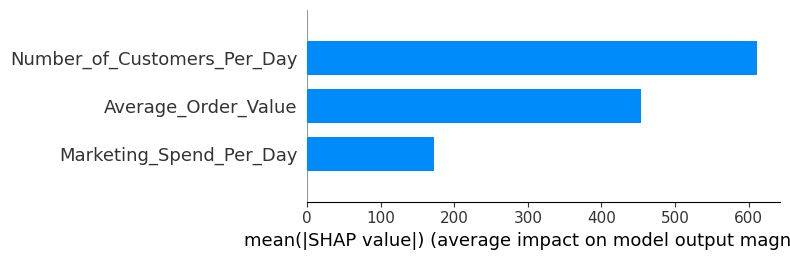

In [65]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

In [67]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test_scaled.iloc[0])

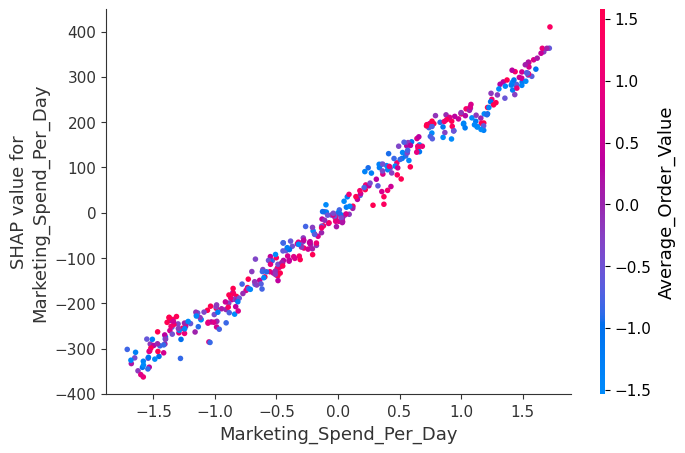

In [68]:
shap.dependence_plot('Marketing_Spend_Per_Day', shap_values.values, X_test_scaled)